In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Unzip

In [ ]:
!unzip /content/gdrive/MyDrive/COVID-19_Radiography_Database.zip


Archive:  /content/gdrive/MyDrive/COVID-19_Radiography_Database.zip
   creating: test/
   creating: test/covid/
  inflating: test/covid/COVID-19 (1).png  
  inflating: test/covid/COVID-19 (108).png  
  inflating: test/covid/COVID-19 (113).png  
  inflating: test/covid/COVID-19 (116).png  
  inflating: test/covid/COVID-19 (121).png  
  inflating: test/covid/COVID-19 (126).png  
  inflating: test/covid/COVID-19 (17).png  
  inflating: test/covid/COVID-19 (3).png  
  inflating: test/covid/COVID-19 (34).png  
  inflating: test/covid/COVID-19 (39).png  
  inflating: test/covid/COVID-19 (42).png  
  inflating: test/covid/COVID-19 (60).png  
  inflating: test/covid/COVID-19 (65).png  
  inflating: test/covid/COVID-19 (69).png  
  inflating: test/covid/COVID-19 (7).png  
  inflating: test/covid/COVID-19 (77).png  
  inflating: test/covid/COVID-19 (83).png  
  inflating: test/covid/COVID-19 (93).png  
  inflating: test/covid/COVID-19 (98).png  
  inflating: test/covid/COVID-19(142).png  
  infl

# Unzipped

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
from torchsummary import summary
import numpy as np
import time
import warnings

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('Default GPU Device: {}'.format(torch.cuda.get_device_name(0)))
else:
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')

Default GPU Device: Tesla T4


# **Preparing Training and Test Sets**

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# **Creating Custom Dataset**



In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    
    def __init__(self, image_dirs, transform):
        
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')  
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])   
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')  
        return self.transform(image), self.class_names.index(class_name)

# **Image Trasnforms**

In [ ]:
train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.Resize(size=(224, 224)),
                  torchvision.transforms.RandomHorizontalFlip(),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
                 torchvision.transforms.Resize(size=(224, 224)),
                 torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# **Prepare Data Loader**

In [ ]:

train_dirs = {
    'normal': '/content/normal',
    'viral': '/content/viral',
    'covid': '/content/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)



Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [ ]:
test_dirs = {
    'normal': '/content/test/normal',
    'viral': '/content/test/viral',
    'covid': '/content/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
batch_size = 6
dloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dloader_train))
print('Number of test batches', len(dloader_test))

Number of training batches 470
Number of test batches 15


# **Data Visualization**

In [ ]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 8))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        plt.rc('axes', labelsize=14)
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

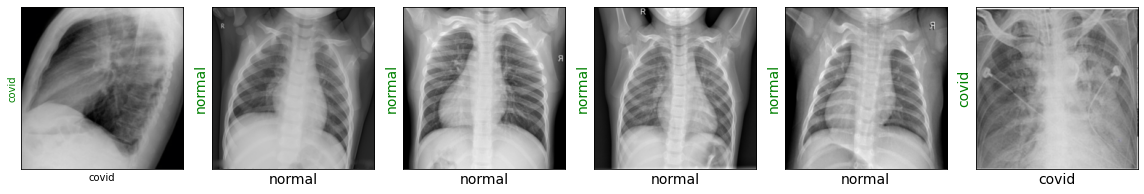

In [ ]:
images, labels = next(iter(dloader_train))
show_images(images, labels, labels)

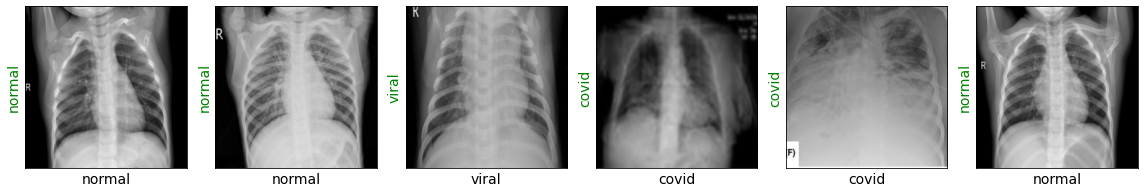

In [ ]:
images, labels = next(iter(dloader_test))
show_images(images, labels, labels)

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc = torch.nn.Linear(in_features=512, out_features=3)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    model.eval()
    images, labels = next(iter(dloader_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


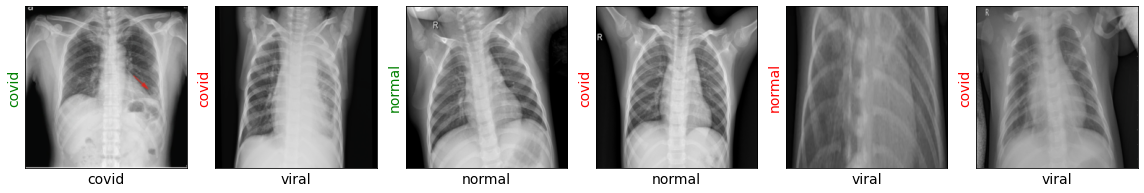

calculating model accuracy before training (should be 1/3 for 3 classes)....
Accuracy of un-trained model: 0.2444


In [ ]:
show_preds()
print('calculating model accuracy before training (should be 1/3 for 3 classes)....')
accuracy = 0
model.eval()      
for val_step, (images, labels) in enumerate(dloader_test):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    accuracy += sum((preds == labels).cpu().numpy())          
accuracy = accuracy / len(test_dataset)
print(f'Accuracy of un-trained model: {accuracy:.4f}')

# **Training The Model**

In [ ]:
def train(epochs):
    
    print('Start training..')
    
    start_time = time.time()
    running_train_loss = []
    running_val_loss = []
    
    for epoch in range(epochs):
        
        print('='*20)
        print(f'Starting epoch {epoch + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() 

        for train_step, (images, labels) in enumerate(dloader_train):
            
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                
                accuracy = 0
                model.eval()

                for val_step, (images, labels) in enumerate(dloader_test):
                    
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                current_time = time.time()
                
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f} Training time: {(current_time-start_time)//60:.0f} minutes')

                show_preds()
                
                running_val_loss.append(val_loss)

                model.train()

                if accuracy >= 0.99:
                    print('Performance condition satisfied, stopping..')
                    save_file = '/content/models/resnet18.pt'
                    torch.save(model.state_dict(), save_file)
                    return running_train_loss, running_val_loss

            train_loss /= (train_step + 1)
            running_train_loss.append(train_loss)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
mkdir models

Start training..
Starting epoch 1/20
Evaluating at step 0
Validation Loss: 1.2100, Accuracy: 0.2222 Training time: 0 minutes


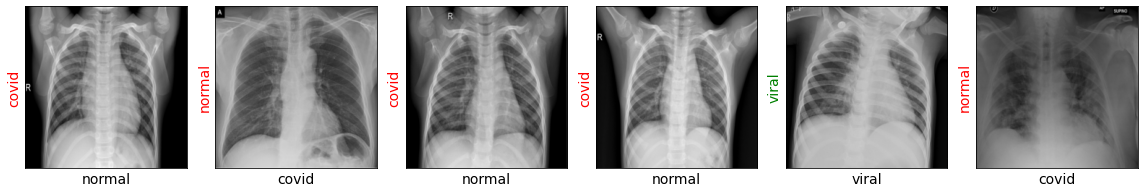

Evaluating at step 20
Validation Loss: 0.7183, Accuracy: 0.7556 Training time: 0 minutes


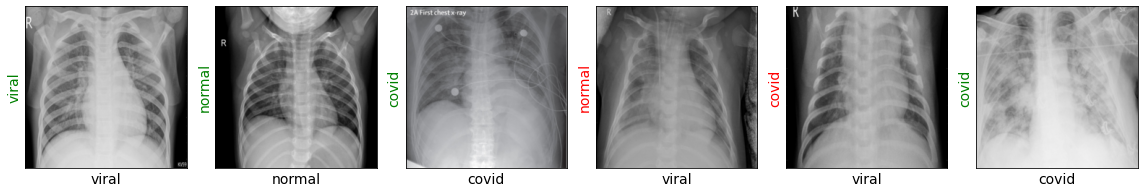

Evaluating at step 40
Validation Loss: 0.2995, Accuracy: 0.9222 Training time: 0 minutes


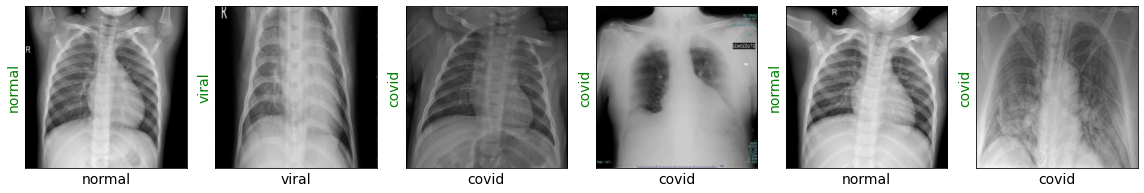

Evaluating at step 60
Validation Loss: 0.2597, Accuracy: 0.9000 Training time: 0 minutes


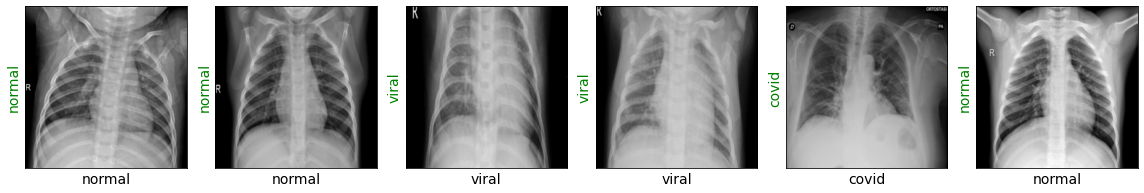

Evaluating at step 80
Validation Loss: 0.1738, Accuracy: 0.9333 Training time: 0 minutes


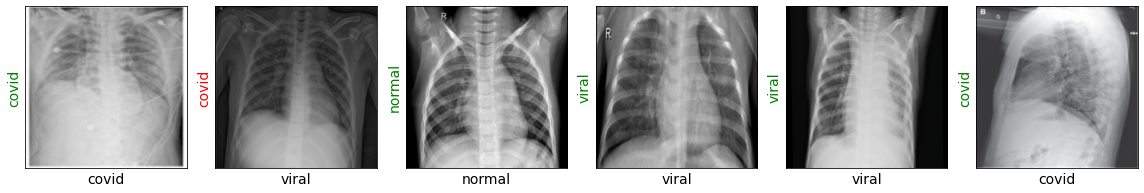

Evaluating at step 100
Validation Loss: 0.1408, Accuracy: 0.9556 Training time: 0 minutes


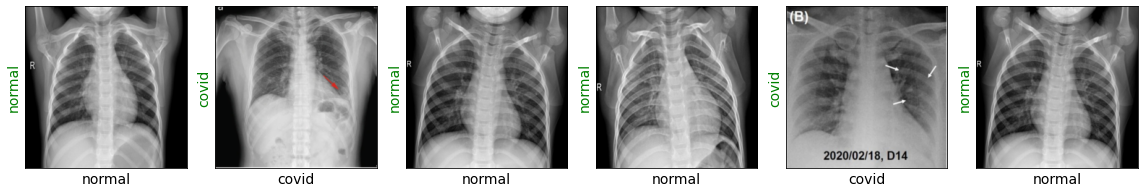

Evaluating at step 120
Validation Loss: 0.1639, Accuracy: 0.9222 Training time: 0 minutes


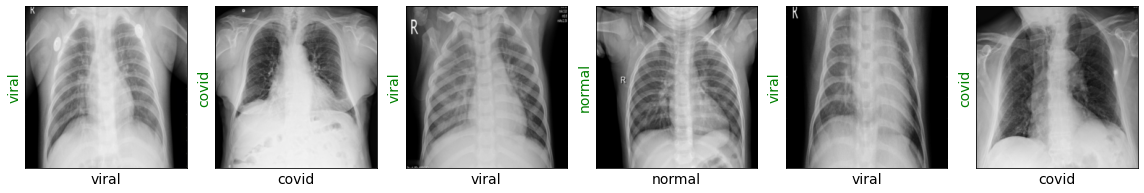

Evaluating at step 140
Validation Loss: 0.1275, Accuracy: 0.9667 Training time: 0 minutes


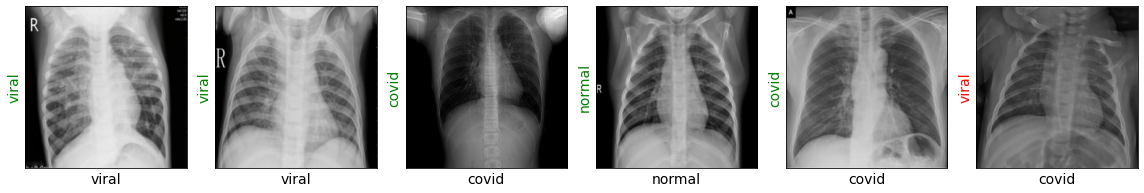

Evaluating at step 160
Validation Loss: 0.1818, Accuracy: 0.9111 Training time: 0 minutes


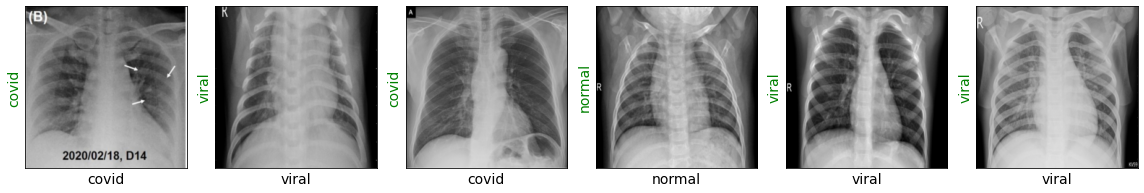

Evaluating at step 180
Validation Loss: 0.1153, Accuracy: 0.9444 Training time: 1 minutes


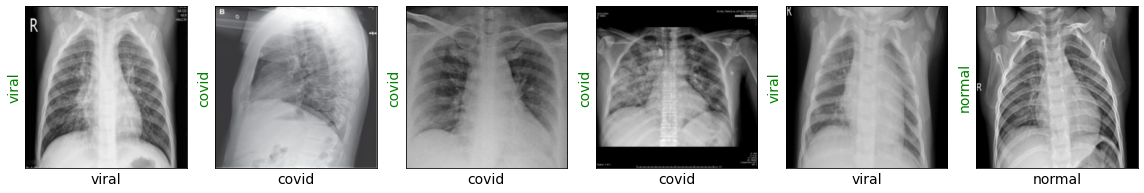

Evaluating at step 200
Validation Loss: 0.1429, Accuracy: 0.9444 Training time: 1 minutes


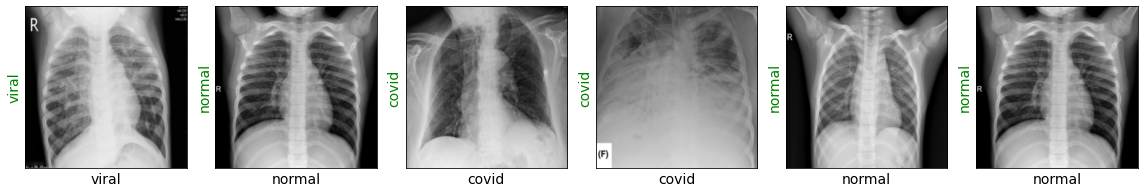

Evaluating at step 220
Validation Loss: 0.1926, Accuracy: 0.9333 Training time: 1 minutes


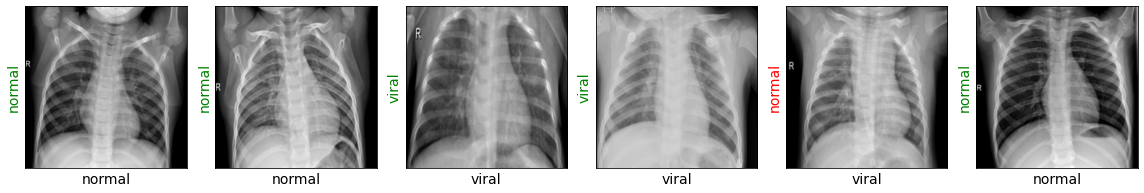

Evaluating at step 240
Validation Loss: 0.1786, Accuracy: 0.9444 Training time: 1 minutes


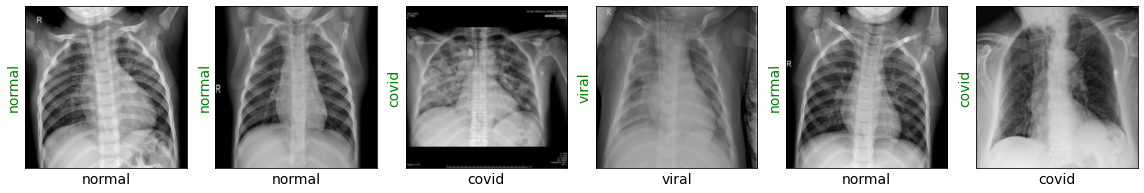

Evaluating at step 260
Validation Loss: 0.1710, Accuracy: 0.9333 Training time: 1 minutes


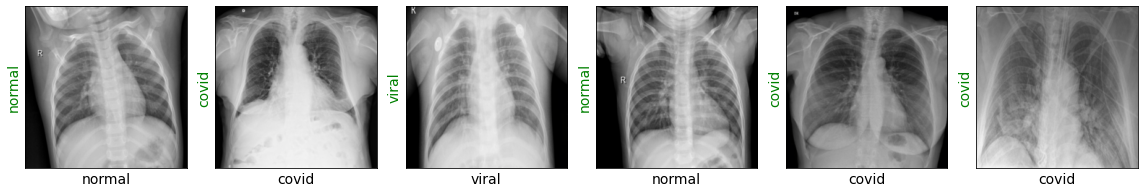

Evaluating at step 280
Validation Loss: 0.1373, Accuracy: 0.9333 Training time: 1 minutes


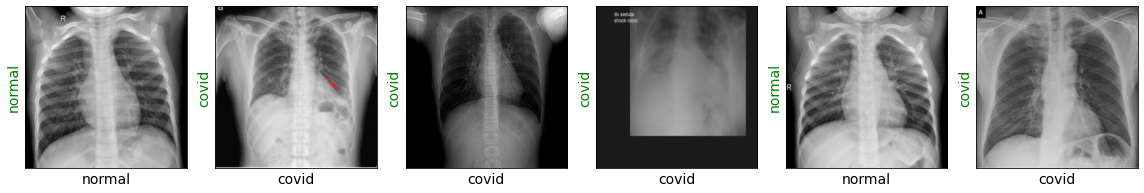

Evaluating at step 300
Validation Loss: 0.1091, Accuracy: 0.9667 Training time: 1 minutes


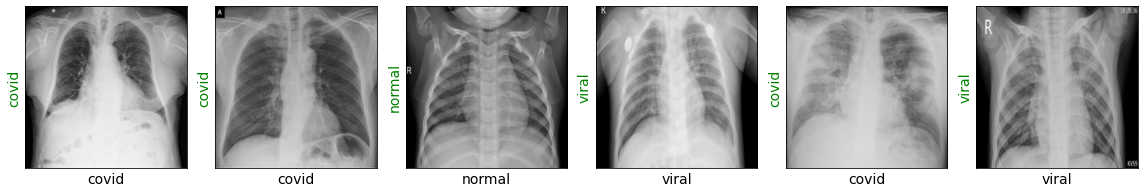

Evaluating at step 320
Validation Loss: 0.1955, Accuracy: 0.9000 Training time: 1 minutes


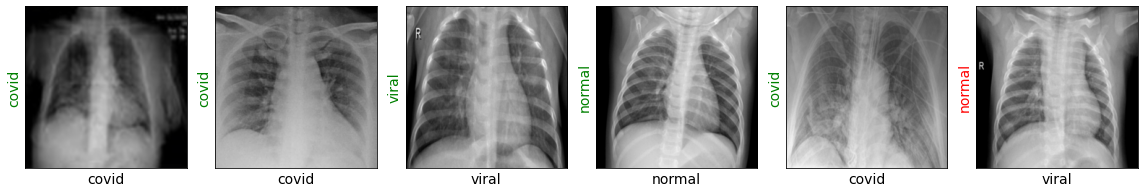

Evaluating at step 340
Validation Loss: 0.1474, Accuracy: 0.9444 Training time: 1 minutes


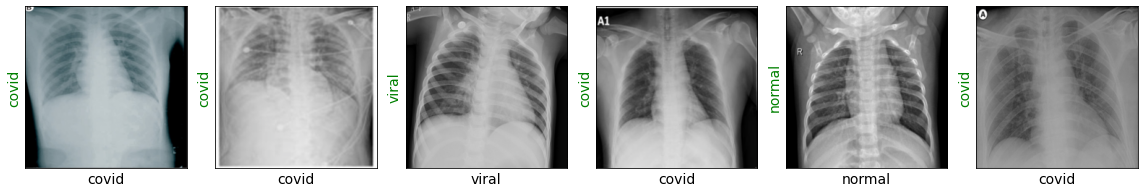

Evaluating at step 360
Validation Loss: 0.1244, Accuracy: 0.9444 Training time: 2 minutes


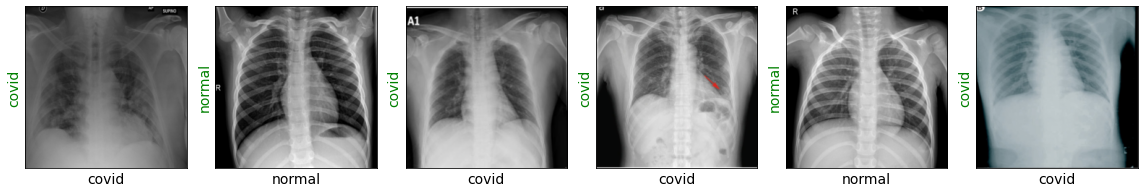

Evaluating at step 380
Validation Loss: 0.1479, Accuracy: 0.9333 Training time: 2 minutes


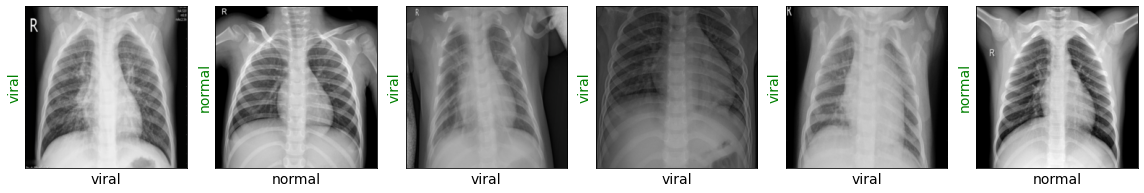

Evaluating at step 400
Validation Loss: 0.0948, Accuracy: 0.9667 Training time: 2 minutes


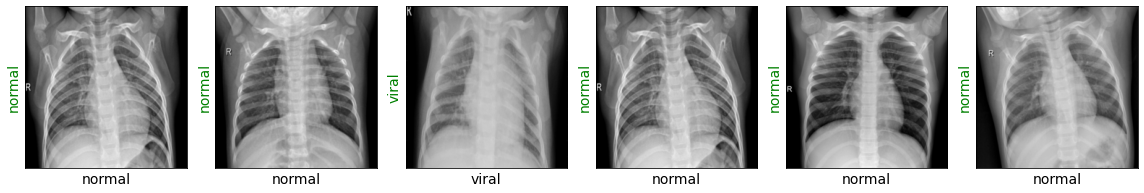

Evaluating at step 420
Validation Loss: 0.1080, Accuracy: 0.9444 Training time: 2 minutes


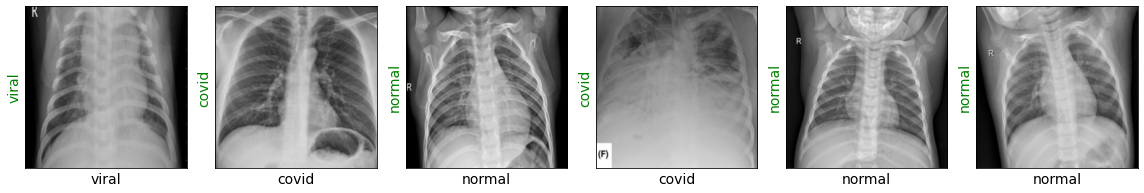

Evaluating at step 440
Validation Loss: 0.1094, Accuracy: 0.9667 Training time: 2 minutes


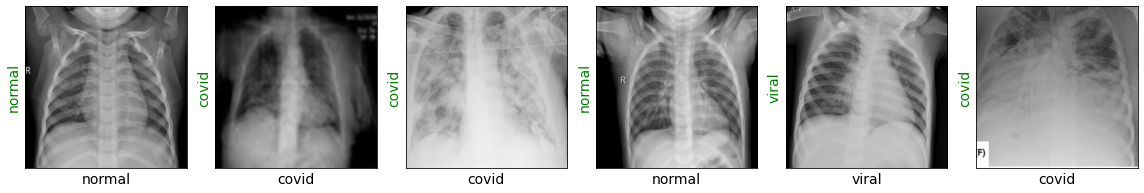

Evaluating at step 460
Validation Loss: 0.0759, Accuracy: 0.9778 Training time: 2 minutes


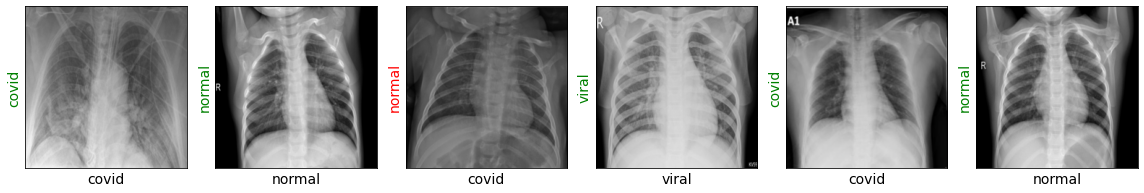

Training Loss: 0.0025
Starting epoch 2/20
Evaluating at step 0
Validation Loss: 0.1508, Accuracy: 0.9556 Training time: 2 minutes


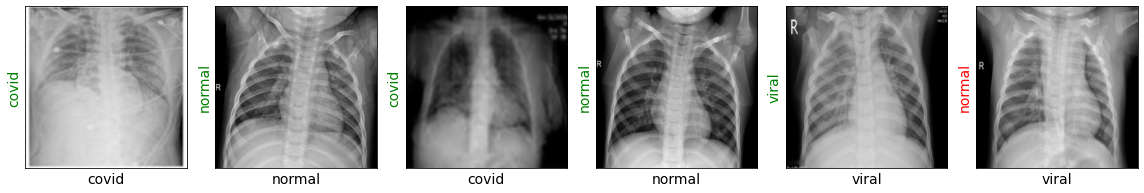

Evaluating at step 20
Validation Loss: 0.0671, Accuracy: 0.9889 Training time: 2 minutes


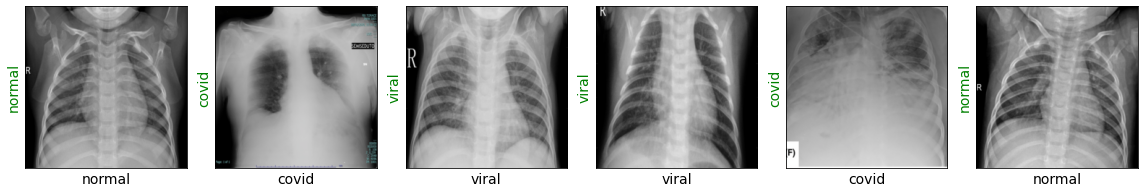

Evaluating at step 40
Validation Loss: 0.0839, Accuracy: 0.9556 Training time: 2 minutes


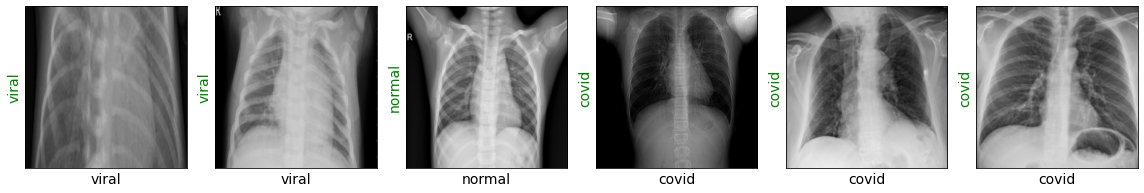

Evaluating at step 60
Validation Loss: 0.1107, Accuracy: 0.9667 Training time: 3 minutes


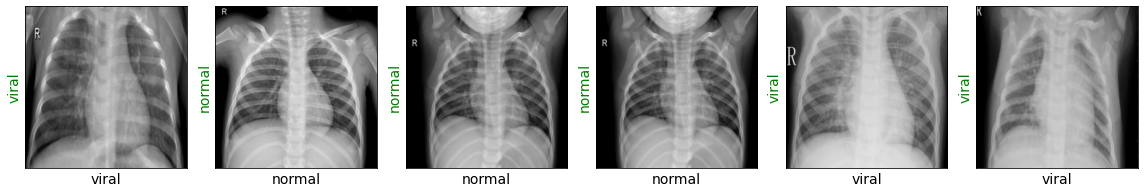

Evaluating at step 80
Validation Loss: 0.1190, Accuracy: 0.9667 Training time: 3 minutes


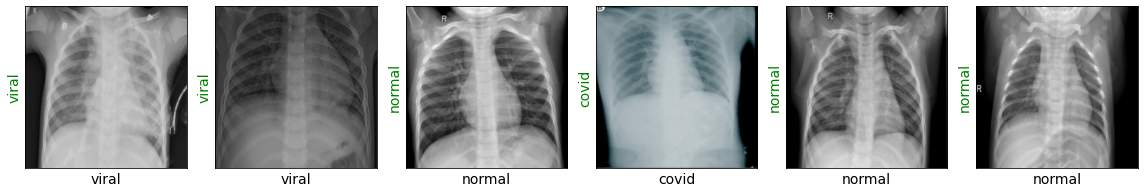

Evaluating at step 100
Validation Loss: 0.0415, Accuracy: 0.9889 Training time: 3 minutes


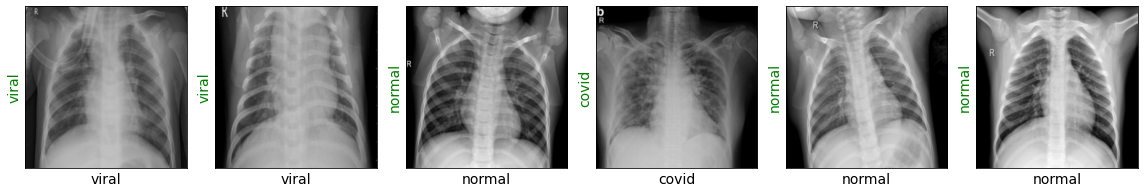

Evaluating at step 120
Validation Loss: 0.0507, Accuracy: 1.0000 Training time: 3 minutes


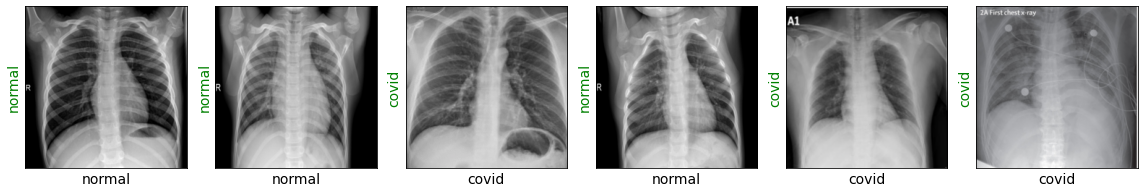

Performance condition satisfied, stopping..
CPU times: user 3min 24s, sys: 5.2 s, total: 3min 29s
Wall time: 3min 26s


In [ ]:
%%time
running_train_loss, running_val_loss = train(epochs=20)

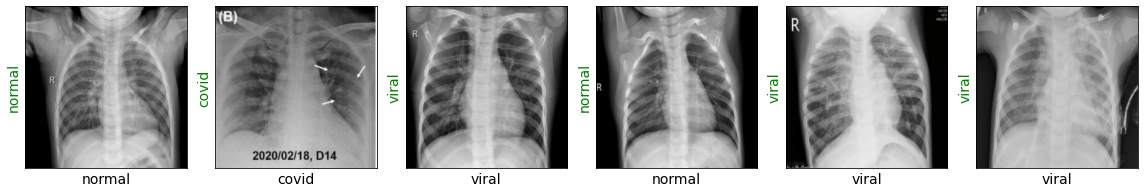

In [ ]:
show_preds()

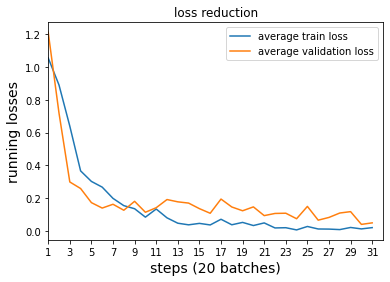

In [ ]:
# Plot Loss reduction profile
steps = len(running_val_loss)
plt.plot(np.arange(1, steps+1,1),running_train_loss[:steps], label='average train loss')
plt.plot(np.arange(1,steps+1,1), running_val_loss[:steps], label='average validation loss')
plt.xticks(range(1,steps+1,2))
plt.xlim(1,steps+1)
plt.xlabel('steps (20 batches)')
plt.ylabel('running losses')
plt.title('loss reduction')
plt.legend(loc='upper right')
filename = 'loss_profile.png'
plt.savefig(filename)
plt.show()

In [ ]:
save_file = '/content/models/resnet18.pt'
if torch.cuda.is_available():
    model.load_state_dict(torch.load(save_file))
else:
    model.load_state_dict(torch.load(save_file, map_location=torch.device('cpu')))

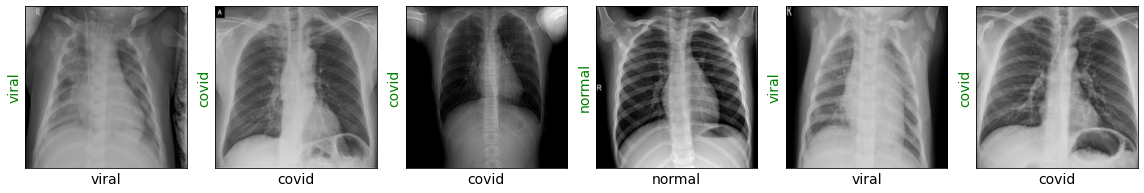

In [ ]:
show_preds()

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def show_preds():
    model.eval()
    images, labels = next(iter(dloader_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

In [ ]:
# Calculate accuracy by class
print('calculating model accuracy after training....')
num_classes = len(class_names)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
    
model.eval()      
for val_step, (images, labels) in enumerate(dloader_test):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    
    correct_tensor = preds.eq(labels.view_as(preds))  
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
for i in range(num_classes):
    if class_total[i] > 0:
            
        print('Test Accuracy on {}:'.format(class_names[i]),
              ' {:.0f}%'.format(100 * class_correct[i] / class_total[i]).ljust(10,' '), 
              '({:.0f}/{:.0f})'.format(np.sum(class_correct[i]), np.sum(class_total[i])))
            
    else:
        print('Test Accuracy of {}: N/A (no training examples)'.format(labels[i]))
                      
print('\nTest Accuracy (Overall):\t {:.0f}%'.format(100. * np.sum(class_correct) / np.sum(class_total)).expandtabs(25),
      '\t({:.0f}/{:.0f})'.format(np.sum(class_correct), np.sum(class_total)).expandtabs(5)) 

calculating model accuracy after training....
Test Accuracy on normal:  100%      (27/27)
Test Accuracy on viral:  96%       (26/27)
Test Accuracy on covid:  94%       (34/36)

Test Accuracy (Overall):  97%      (87/90)


In [ ]:
import pickle

In [ ]:
with open('covid19pred.pkl','wb') as f:
  pickle.dump(model,f)

In [ ]:
new_model = pickle.load(open('covid19pred.pkl','rb'))

In [ ]:
new_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  